#使用OpenImage的數據集訓練YOLOv4-tiny

透過 download_open_image.ipynb 下載自己想要的數據集，接著再使用 train_darknet_tiny_with_openimage.ipnb 來進行訓練以及測試，建議綁定雲端硬碟保存訓練好的權重。

>參考資料
* https://www.youtube.com/watch?v=U2V2tUwquAA
* https://github.com/EscVM/OIDv4_ToolKit

#[Open Image V6](https://storage.googleapis.com/openimages/web/index.html)

其中有600個類別的對像有15440132個方框標註,19,794個類別的30,113,078個圖像級標籤。其中我們比較關注Explore，Description和Download 三個功能。


#1.建立工作環境

掛接到雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


建立工作目錄

In [ ]:
import os

working_dir = '/content/gdrive/MyDrive/yolov4'

try:
  os.makedirs(working_dir)
  print('Create directory')
except FileExistsError:
  print('Directory is exists!')

os.chdir(working_dir)
print(f'Move to working space ({os.getcwd()})')

Directory is exists!
Move to working space (/content/gdrive/MyDrive/yolov4)


#2.選擇你想要的數據進行下載


##2.1 下載 & 安裝 OIDv4 Toolkits

In [ ]:
!git clone https://github.com/theAIGuysCode/OIDv4_ToolKit.git
!pip3 install -r ./OIDv4_ToolKit/requirements.txt

fatal: destination path 'OIDv4_ToolKit' already exists and is not an empty directory.
     |████████████████████████████████| 3.6MB 6.8MB/s 
     |████████████████████████████████| 7.4MB 27.5MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 552kB 44.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: botocore 1.20.57 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: docutils 0.17
    Uninstalling docutils-0.17:
      Successfully uninstalled docutils-0.17


##2.2 下載 Open Image V6 + 的圖片 ( * )

* 300張Apple的照片大概10分鐘 (100M的話)

* 多標籤的範例
```
%cd '/content/gdrive/MyDrive/yolov4/OIDv4_ToolKit'
!python ./main.py downloader --classes 'Human eye' 'Human mouth' 'Human nose' --type_csv train --limit 500
```

In [ ]:
import os
import shutil

# 確保移動到對的目錄
working_dir = '/content/gdrive/MyDrive/yolov4/OIDv4_ToolKit'
os.chdir(working_dir)

# 如果有舊有的資料集要先刪除
target_dir = 'OID/Dataset/train'
if os.path.exists(target_dir) is True:
  shutil.rmtree(target_dir, ignore_errors=True)

##############################################################################################################################

# 於 classes 中找 特定 類別
!python ./main.py downloader --classes 'Apple' --type_csv train --limit 300 --multiclasses 1 --y --n_threads 4

##############################################################################################################################


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Apple'] together.

Apple
    [INFO] | Downloading train images.
    [INFO] | [INFO] Found 1078 online images for train.
    [INFO] | Limiting to 300 images.
    [INFO] | Download of 300 images i

##2.3 顯示下載的圖片 ( * )

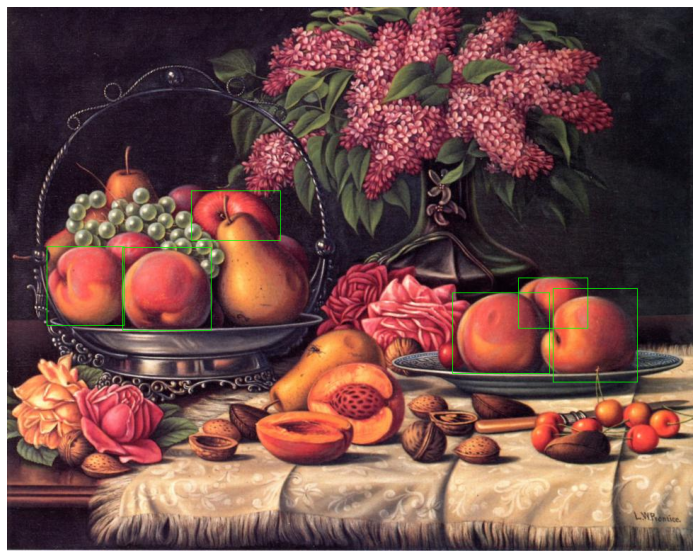

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

##############################################################################################################################

task = 'Apple'

##############################################################################################################################

file_path = f'OID/Dataset/train/{task}'
label_dir = f'OID/Dataset/train/{task}/Label'

# 隨機選一張圖片
import random
file_list = os.listdir(file_path)
trg_id = random.randint(0, len(file_list))

# 取得 圖檔 以及 標籤檔
title, ext = os.path.splitext( file_list[trg_id] )
img_path = os.path.join(file_path, title+'.jpg')
label_path = os.path.join(label_dir, title+'.txt')

# 讀取圖片
img = cv2.imread(img_path)

# 開啟標籤檔 並繪製 bonding box
with open(label_path) as f:

  for line in f.readlines():
    
    # 取得座標
    x1,y1,x2,y2 = [ round(float(c)) for c in line.rstrip('\n').split(' ')[1:]]    

    # 繪製bbox
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

# 在 Jupyter Notebook 上需要轉換成 Matplot 顯示才行
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


##2.4 產生YOLOv4可用標籤

原本的格式為 class_name x1 y1 x2 y2

而YOLO的格式為 class_id center_x center_y width height

* width = x2 - x1

* height = y2 - y1

* center_x = x1 + width//2

* center_y = y1 + height//2

* 根據圖片大小進行正規化 縮放到 [0, 1] 之間

##重點

OIDv4_Toolkit目錄中的classes.txt要修改哦！

In [ ]:
%cd '/content/gdrive/MyDrive/yolov4/OIDv4_ToolKit'

!python ./convert_annotations.py

/content/gdrive/MyDrive/yolov4/OIDv4_ToolKit
Currently in subdirectory: train
Converting annotations for class:  Apple
100% 300/300 [00:22<00:00, 13.38it/s]


#3. 將資料複製到 Darknet/data 當中 ( * )

In [ ]:
import shutil

##############################################################################################################################

# task = 'custom'
# task = 'Apple'

##############################################################################################################################

shutil.copytree(f'/content/gdrive/MyDrive/yolov4/OIDv4_ToolKit/OID/Dataset/train/{task}', f'../darknet/data/{task}')

print('Finish')

Finish


#4. 刪除標籤資料夾

In [ ]:
import os

##############################################################################################################################

# task = 'Apple'

##############################################################################################################################

os.chdir('/content/gdrive/MyDrive/yolov4/darknet/')
shutil.rmtree(f'./data/{task}/Label')

---

#完成，接著開啟 train_darknet_tiny_with_openimage.ipynb

---

